<a href="https://colab.research.google.com/github/jaaaamj0711/DACON/blob/main/%ED%95%9C%EA%B5%AD%20%EB%B6%80%EB%8F%99%EC%82%B0%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%8B%9C%EA%B0%81%ED%99%94%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/cluster_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 산업별 KOSPI 군집분석



In [ ]:
!pip install tslearn
!pip install kneed

In [2]:
from sklearn.preprocessing import StandardScaler


from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, cdist_dtw

from sklearn.cluster import AgglomerativeClustering

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from kneed import KneeLocator

from datetime import date
import numpy as np
import pandas as pd
import random
import os

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [3]:
df = pd.read_csv("/content/drive/MyDrive/open (2)/코스피_산업별_주가지수.csv", encoding = "CP949")
df.head()

,날짜,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,운수장비,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
0,2000-01-01,1186.95,1140.02,355.40,381.45,797.70,964.28,500.98,1477.68,399.13,4250.02,785.91,282.71,287.89,961.33,101.24,726.69,809.01,328.16,160.37,2315.58,3397.18,760.89
1,2000-02-01,1051.13,1064.90,350.45,327.25,716.03,1264.12,411.56,1254.39,378.20,3704.27,870.82,217.45,240.64,811.02,77.23,673.50,753.98,253.12,112.39,1906.11,2812.40,952.39
2,2000-03-01,1196.83,1074.09,375.93,354.76,755.94,1201.82,435.58,1225.27,346.24,4655.30,747.86,226.72,265.52,898.48,74.70,733.95,703.72,213.12,104.76,1397.07,2451.53,810.17
3,2000-04-01,1017.99,911.25,313.76,305.77,624.65,997.37,411.75,998.09,279.67,4009.41,649.91,188.30,221.81,903.47,69.75,550.21,540.78,180.92,101.69,987.68,1947.97,655.84
4,2000-05-01,979.88,771.48,250.99,230.29,527.90,873.13,360.92,977.54,239.36,3971.40,521.46,200.83,187.06,842.20,62.24,433.71,643.54,185.72,103.74,1072.90,2118.68,630.57


In [4]:
df = df.set_index('날짜')
df = pd.DataFrame(df)
df

,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,운수장비,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1186.95,1140.02,355.40,381.45,797.70,964.28,500.98,1477.68,399.13,4250.02,785.91,282.71,287.89,961.33,101.24,726.69,809.01,328.16,160.37,2315.58,3397.18,760.89
2000-02-01,1051.13,1064.90,350.45,327.25,716.03,1264.12,411.56,1254.39,378.20,3704.27,870.82,217.45,240.64,811.02,77.23,673.50,753.98,253.12,112.39,1906.11,2812.40,952.39
2000-03-01,1196.83,1074.09,375.93,354.76,755.94,1201.82,435.58,1225.27,346.24,4655.30,747.86,226.72,265.52,898.48,74.70,733.95,703.72,213.12,104.76,1397.07,2451.53,810.17
2000-04-01,1017.99,911.25,313.76,305.77,624.65,997.37,411.75,998.09,279.67,4009.41,649.91,188.30,221.81,903.47,69.75,550.21,540.78,180.92,101.69,987.68,1947.97,655.84
2000-05-01,979.88,771.48,250.99,230.29,527.90,873.13,360.92,977.54,239.36,3971.40,521.46,200.83,187.06,842.20,62.24,433.71,643.54,185.72,103.74,1072.90,2118.68,630.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,6638.83,3785.52,248.76,418.97,6175.73,19761.92,1853.09,3620.72,952.04,24527.27,2523.46,1799.29,369.32,697.21,94.72,1738.56,326.59,375.54,194.74,1887.20,12033.64,1572.83
2020-12-01,7548.59,3940.15,254.64,392.31,6503.57,21085.04,2071.15,4112.28,972.02,29788.48,2795.33,1924.37,394.67,844.83,106.20,1755.95,325.16,392.51,185.12,1903.90,12660.89,1639.72
2021-01-01,7868.24,4006.58,267.45,393.32,7161.87,19286.05,2357.91,3908.33,960.55,30849.19,2740.77,2281.59,392.02,737.42,107.25,1862.49,331.28,390.76,166.82,1905.27,11596.24,1752.90


## 산업별 시각화

In [5]:
column_name = df.columns
column_name

Index(['제조업', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업', '금융업',
       '은행', '증권', '보험', '서비스업'],
      dtype='object')

In [6]:
fig = go.Figure()

for category in column_name:
  fig.add_trace(go.Scatter(y=df[category], mode = 'lines', name = category))

fig.show()

### 정규화 진행

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig = go.Figure()

for category in column_name:
    df[category] = scaler.fit_transform(pd.DataFrame(df[category]))
    fig.add_trace(go.Scatter(y=df[category], mode='lines', name=category))

fig.show()

In [8]:
df2 = to_time_series_dataset(df.values.T)

In [9]:
value = []

for k in range(1, 8):
    model = TimeSeriesKMeans(n_clusters=k, metric='euclidean', verbose=False, random_state=42)
    model.fit(df2)
    value.append(model.inertia_)
    print(f'군집 수 {k}개 일때 Inertia value: {value[-1]}')

군집 수 1개 일때 Inertia value: 120.47140586709601
군집 수 2개 일때 Inertia value: 76.30313876284393
군집 수 3개 일때 Inertia value: 58.36152555998181
군집 수 4개 일때 Inertia value: 48.83906683529538
군집 수 5개 일때 Inertia value: 41.85136599893064
군집 수 6개 일때 Inertia value: 33.718062730702584
군집 수 7개 일때 Inertia value: 26.81074642446698


Inertia value: 각 중심점에서 군집의 데이타간거리를 합산한값  


 -> 즉 군집의 응집도를 나타낸 값으로 값이 작을수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있다.

k-value: 3


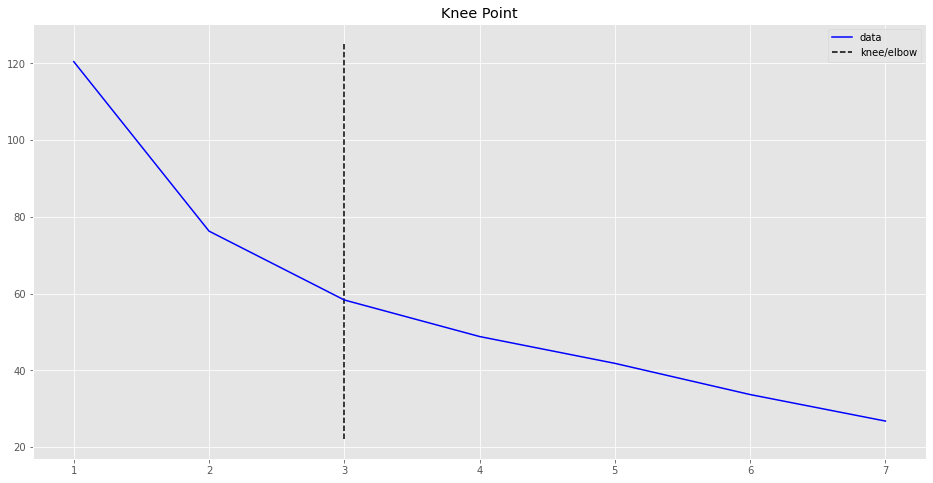

In [10]:
knee = KneeLocator(range(1, len(value)+1), value, curve='convex', direction='decreasing', online=True)
knee.plot_knee(figsize=(16,8))
print(f'k-value: {knee.knee}')

### 군집 개수 3개로 설정(euclidean)

In [11]:
euclidean = TimeSeriesKMeans(n_clusters=3, metric='euclidean', verbose=True, random_state=42)
euclidean_label = euclidean.fit_predict(df2)

101.477 --> 65.978 --> 60.546 --> 58.362 --> 58.362 --> 


In [12]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_label)
default_cluster = "군집 1"

for idx in range(len(cluster_value)):
    for element_idx in np.argwhere(euclidean_label == cluster_value[idx]):
        fig.add_trace(go.Scatter(x=df.iloc[:, element_idx].index, y=df.iloc[:, element_idx].values.flatten(), 
                                 name=df.columns[element_idx][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {idx+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=df.iloc[:, element_idx].index, 
                             y=euclidean.cluster_centers_[cluster_value[idx]].flatten(), 
                             name=f'군집 {idx+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {idx+1}'== default_cluster)))
    plot_names.extend([f'군집 {idx+1}']*(len(np.argwhere(euclidean_label == cluster_value[idx]))+1))

for i in range(len(cluster_value)):
    states.append(f'군집 {i+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {i+1}',
                        args = [{'visible': [f'군집 {i+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])
fig.show()

In [13]:
from sklearn.decomposition import PCA

In [14]:
nsamle, nx, ny = df2.shape
df2_pca = df2.reshape((nsamle,nx*ny))

In [15]:
pca = PCA(n_components=2) 
pca_fit = pca.fit_transform(df2_pca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



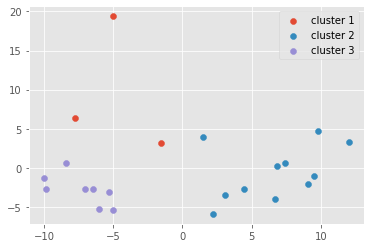

In [16]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(df2_pca)

for i in range(3):
  label_name = "cluster " +str(i+1)
  plt.scatter(pca_fit[[euclidean_label==i]][:,0],pca_fit[[euclidean_label==i]][:,1],label=label_name)
  
plt.legend()
plt.show()

### 군집 개수 4개로 설정(euclidean)

In [17]:
euclidean = TimeSeriesKMeans(n_clusters=4, metric='euclidean', verbose=True, random_state=42)
euclidean_label = euclidean.fit_predict(df2)

86.684 --> 56.455 --> 51.023 --> 48.839 --> 48.839 --> 


In [18]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_label)
default_cluster = "군집 1"

for idx in range(len(cluster_value)):
    for element_idx in np.argwhere(euclidean_label == cluster_value[idx]):
        fig.add_trace(go.Scatter(x=df.iloc[:, element_idx].index, y=df.iloc[:, element_idx].values.flatten(), 
                                 name=df.columns[element_idx][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {idx+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=df.iloc[:, element_idx].index, 
                             y=euclidean.cluster_centers_[cluster_value[idx]].flatten(), 
                             name=f'군집 {idx+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {idx+1}'== default_cluster)))
    plot_names.extend([f'군집 {idx+1}']*(len(np.argwhere(euclidean_label == cluster_value[idx]))+1))

for i in range(len(cluster_value)):
    states.append(f'군집 {i+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {i+1}',
                        args = [{'visible': [f'군집 {i+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



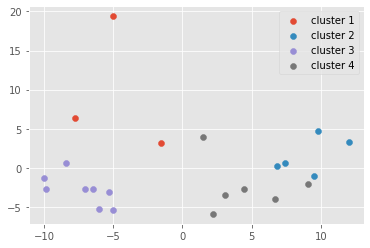

In [19]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(df2_pca)

for i in range(4):
  label_name = "cluster " +str(i+1)
  plt.scatter(pca_fit[[euclidean_label==i]][:,0],pca_fit[[euclidean_label==i]][:,1],label=label_name)
plt.legend()

In [20]:
df.head()

,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,운수장비,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,-1.257398,-1.234981,1.512313,1.015728,-1.307052,-0.983268,-1.192945,-1.377507,-1.057901,-0.872436,-0.713345,-1.434127,-0.845365,-0.075241,-0.515999,-1.146584,6.476675,-0.672596,-1.127249,0.539378,-1.636147,-0.218858
2000-02-01,-1.340759,-1.289411,1.454061,0.292311,-1.350913,-0.915108,-1.393847,-1.497909,-1.105160,-0.967522,-0.620683,-1.514615,-1.223488,-0.616328,-0.826617,-1.211101,5.712832,-1.314855,-1.769653,-0.032235,-1.732073,0.334471
2000-03-01,-1.251334,-1.282753,1.753913,0.659491,-1.329480,-0.929270,-1.339880,-1.513611,-1.177324,-0.801824,-0.754868,-1.503182,-1.024383,-0.301488,-0.859347,-1.137778,5.015199,-1.657211,-1.871811,-0.742847,-1.791270,-0.076466
2000-04-01,-1.361099,-1.400742,1.022288,0.005613,-1.399988,-0.975746,-1.393420,-1.636110,-1.327636,-0.914357,-0.861760,-1.550567,-1.374177,-0.283525,-0.923385,-1.360647,2.753514,-1.932808,-1.912916,-1.314348,-1.873873,-0.522394
2000-05-01,-1.384490,-1.502016,0.283601,-1.001832,-1.451948,-1.003988,-1.507621,-1.647191,-1.418654,-0.920980,-1.001937,-1.535113,-1.652267,-0.504086,-1.020542,-1.501957,4.179872,-1.891725,-1.885468,-1.195383,-1.845870,-0.595411


In [21]:
a = pd.read_csv("/content/drive/MyDrive/open (2)/주택매매가격지수(KB).csv")
a.head()

,Unnamed: 0,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
0,1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1,1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
2,1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
3,1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
4,1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588


In [22]:
a = a.rename(columns = {'Unnamed: 0':'날짜'})
a = a.set_index('날짜')
a = pd.DataFrame(a)
a

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
날짜,,,,,,
1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588
...,...,...,...,...,...,...
2020-11-01,107.125,104.334,106.398,107.506,114.853,112.139
2020-12-01,108.586,104.909,107.237,109.346,116.365,113.532
2021-01-01,109.878,105.303,107.895,111.005,118.230,114.974


In [72]:
a = a.loc["2000-01-01": "2021-03-01"]
a = a['총지수[2019.01=100]']

In [73]:
result = pd.concat([df, a], axis=1)
result.head()

,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,운수장비,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업,총지수[2019.01=100]
날짜,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,-1.257398,-1.234981,1.512313,1.015728,-1.307052,-0.983268,-1.192945,-1.377507,-1.057901,-0.872436,-0.713345,-1.434127,-0.845365,-0.075241,-0.515999,-1.146584,6.476675,-0.672596,-1.127249,0.539378,-1.636147,-0.218858,48.819
2000-02-01,-1.340759,-1.289411,1.454061,0.292311,-1.350913,-0.915108,-1.393847,-1.497909,-1.105160,-0.967522,-0.620683,-1.514615,-1.223488,-0.616328,-0.826617,-1.211101,5.712832,-1.314855,-1.769653,-0.032235,-1.732073,0.334471,49.027
2000-03-01,-1.251334,-1.282753,1.753913,0.659491,-1.329480,-0.929270,-1.339880,-1.513611,-1.177324,-0.801824,-0.754868,-1.503182,-1.024383,-0.301488,-0.859347,-1.137778,5.015199,-1.657211,-1.871811,-0.742847,-1.791270,-0.076466,49.234
2000-04-01,-1.361099,-1.400742,1.022288,0.005613,-1.399988,-0.975746,-1.393420,-1.636110,-1.327636,-0.914357,-0.861760,-1.550567,-1.374177,-0.283525,-0.923385,-1.360647,2.753514,-1.932808,-1.912916,-1.314348,-1.873873,-0.522394,49.286
2000-05-01,-1.384490,-1.502016,0.283601,-1.001832,-1.451948,-1.003988,-1.507621,-1.647191,-1.418654,-0.920980,-1.001937,-1.535113,-1.652267,-0.504086,-1.020542,-1.501957,4.179872,-1.891725,-1.885468,-1.195383,-1.845870,-0.595411,49.234


In [28]:
# 한글 폰트 사용을 위한 설정
!apt-get update -qq
!apt-get install fonts-nanum* -qq

E: Failed to fetch https://cloud.r-project.org/bin/linux/ubuntu/bionic-cran40/Packages.gz  File has unexpected size (60516 != 60902). Mirror sync in progress? [IP: 65.8.183.2 443]
   Hashes of expected file:
    - Filesize:60902 [weak]
    - SHA512:39b749b2afabc28d2733f6a1c101f35b09aeba7abb4fcaae0e7dec3aab6f1e62c8934fc5a53d22a2ce44382f2759ecd1d40a8925c150c7b40cf64028302fefcb
    - SHA256:4600cf430259efa527750ffc0479e947462abd6a402cc16caa2507c0c842f483
    - MD5Sum:355484ded9a62e6640925031e2f0cf23 [weak]
   Release file created at: Sat, 22 May 2021 01:08:27 +0000
E: Some index files failed to download. They have been ignored, or old ones used instead.


In [29]:
import matplotlib.font_manager as fm
fm._rebuild()
plt.rc('font', family='NanumGothic')

In [ ]:
for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

In [74]:
corr_df1 = result.corr()
corr_df1 = corr_df1.apply(lambda x: round(x ,2))

In [87]:
corr1 = corr_df1.nlargest(10, '총지수[2019.01=100]')
corr1 = corr1[list(corr1.index)]
corr1

,총지수[2019.01=100],제조업,화학,의료정밀,서비스업,음식료품,전기전자,의약품,보험,비금속광물
총지수[2019.01=100],1.00,0.95,0.93,0.89,0.89,0.88,0.86,0.83,0.77,0.75
제조업,0.95,1.00,0.96,0.92,0.95,0.86,0.93,0.86,0.73,0.75
화학,0.93,0.96,1.00,0.91,0.93,0.89,0.82,0.79,0.79,0.71
의료정밀,0.89,0.92,0.91,1.00,0.90,0.85,0.85,0.84,0.76,0.74
서비스업,0.89,0.95,0.93,0.90,1.00,0.87,0.88,0.86,0.69,0.77
음식료품,0.88,0.86,0.89,0.85,0.87,1.00,0.71,0.71,0.81,0.74
전기전자,0.86,0.93,0.82,0.85,0.88,0.71,1.00,0.93,0.48,0.78
의약품,0.83,0.86,0.79,0.84,0.86,0.71,0.93,1.00,0.47,0.85
보험,0.77,0.73,0.79,0.76,0.69,0.81,0.48,0.47,1.00,0.48
비금속광물,0.75,0.75,0.71,0.74,0.77,0.74,0.78,0.85,0.48,1.00


In [78]:
result2 = result.loc["2003-01-01": "2008-12-01"]

In [79]:
corr_df2 = result2.corr()
corr_df2 = corr_df2.apply(lambda x: round(x ,2))

In [86]:
corr2 = corr_df2.nlargest(10, '총지수[2019.01=100]')
corr2 = corr2[list(corr2.index)]
corr2

,총지수[2019.01=100],보험,철강금속,기계,화학,운수창고업,의약품,제조업,의료정밀,운수장비
총지수[2019.01=100],1.00,0.90,0.89,0.86,0.85,0.85,0.84,0.82,0.82,0.81
보험,0.90,1.00,0.96,0.97,0.96,0.95,0.96,0.96,0.91,0.96
철강금속,0.89,0.96,1.00,0.98,0.98,0.98,0.92,0.95,0.92,0.96
기계,0.86,0.97,0.98,1.00,0.98,0.98,0.93,0.96,0.93,0.97
화학,0.85,0.96,0.98,0.98,1.00,0.99,0.94,0.98,0.90,0.98
운수창고업,0.85,0.95,0.98,0.98,0.99,1.00,0.92,0.96,0.90,0.97
의약품,0.84,0.96,0.92,0.93,0.94,0.92,1.00,0.97,0.91,0.96
제조업,0.82,0.96,0.95,0.96,0.98,0.96,0.97,1.00,0.93,0.99
의료정밀,0.82,0.91,0.92,0.93,0.90,0.90,0.91,0.93,1.00,0.94
운수장비,0.81,0.96,0.96,0.97,0.98,0.97,0.96,0.99,0.94,1.00


In [82]:
result3 = result.loc["2020-02-01": "2021-03-01"]

In [83]:
corr_df3 = result3.corr()
corr_df3 = corr_df3.apply(lambda x: round(x ,2))

In [85]:
corr3 = corr_df3.nlargest(10, '총지수[2019.01=100]')
corr3 = corr3[list(corr3.index)]
corr3

,총지수[2019.01=100],운수창고업,제조업,화학,비금속광물,운수장비,전기전자,철강금속,의료정밀,증권
총지수[2019.01=100],1.00,0.98,0.97,0.97,0.97,0.97,0.96,0.95,0.95,0.95
운수창고업,0.98,1.00,0.96,0.96,0.96,0.95,0.95,0.97,0.96,0.95
제조업,0.97,0.96,1.00,0.99,0.96,0.98,0.99,0.94,0.95,0.96
화학,0.97,0.96,0.99,1.00,0.96,0.98,0.95,0.91,0.94,0.97
비금속광물,0.97,0.96,0.96,0.96,1.00,0.96,0.94,0.95,0.96,0.92
운수장비,0.97,0.95,0.98,0.98,0.96,1.00,0.96,0.92,0.92,0.96
전기전자,0.96,0.95,0.99,0.95,0.94,0.96,1.00,0.94,0.94,0.92
철강금속,0.95,0.97,0.94,0.91,0.95,0.92,0.94,1.00,0.95,0.93
의료정밀,0.95,0.96,0.95,0.94,0.96,0.92,0.94,0.95,1.00,0.92
증권,0.95,0.95,0.96,0.97,0.92,0.96,0.92,0.93,0.92,1.00
